# Forecast

In [ ]:
# !pip install git+https://github.com/patricksferraz/pyaiutils.git@chore/requirements

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import pyaiutils as pai
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import pickle
import shap
import os

#### Variáveis

In [2]:
DATASET = 'downloads/pre-processed'
OUTPUT = 'downloads/results'

#### Funções

Função para verificar a existência do path, caso o caminho não exista, ele é criado
- path: caminho

In [3]:
def sync_path(path: str) -> None:
    lvs = path.split('/')
    for lv in range(1, len(lvs)+1):
        check = '/'.join(lvs[:lv])
        if not os.path.exists(check):
            os.mkdir(check)

Função para exibir o o histórico de treinamento

- history: history de treinamento

In [4]:
def show_history(path: str):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    ax[0].set_ylabel('Categorical Crossentropy')
    ax[0].plot(range(len(history['loss'])), history['loss'], label='Train loss')
    ax[0].plot(range(len(history['loss'])), history['val_loss'], label='Validation loss')
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(range(len(history['loss'])), history['acc'], label='Train acc')
    ax[1].plot(range(len(history['loss'])), history['val_acc'], label='Validation acc')
    ax[1].legend()
    
    plt.show()

Metrics

In [5]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [7]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Função para avaliação do modelo
- model: modelo
- x_test: dataframe de entrada
- y_test: dataframe alvo
- class_names: classes
- path: caminho para armazenar os resultados

In [8]:
def evaluate(
    model: tf.keras.Sequential,
    x_test: np.ndarray,
    y_test: np.ndarray,
    class_names: [str],
    path: str
) -> None:
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
    display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

## Classificação

Algoritmos de classificação

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Métricas de avaliação

Matriz de Confusão | Recall vs Precision | Equação de 4 diferentes métricas
- | - | -
![](https://miro.medium.com/max/1400/1*N6I3pi0prhiJ_Y85HAx4wA.png) | ![](https://miro.medium.com/max/700/0*uhuG2rhX6XzNC43X.png) | ![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

### COVID/NÃO-COVID

Carregando dataframe:
- `f'{DATASET}/20-21.csv.gz'`

|Sintomas|Comorbidades|CS_SEXO|NU_IDADE_N|CLASSI_FIN|EVOLUCAO|
|--|--|--|--|--|--|
|1. Sim|1. Sim|F: Feminino||0. Não Covid|1. Cura|
|2. Não|2. Não|M: Masculino||1. Covid|2. Óbito|
|9. Ignorado|9. Ignorado|I: Ignorado|||9. Ignorado|


Delimitando as colunas de interesse

In [28]:
symptoms = [
    'FEBRE',
    'TOSSE',
    'GARGANTA',
    'DISPNEIA',
    'DESC_RESP',
    'SATURACAO',
    'DIARREIA',
]
comorbidities = [
    'PUERPERA',
    'CARDIOPATI',
    'SIND_DOWN',
    'HEPATICA',
    'NEUROLOGIC',
    'PNEUMOPATI',
    'IMUNODEPRE',
    'RENAL',
    'OBESIDADE',
]
interest_cols = [
    *symptoms,
    *comorbidities,
    'CS_SEXO',
    'NU_IDADE_N',
    'CLASSI_FIN',
]

Carregando os dados do OpenDataSUS

In [29]:
df_ods = pd.read_csv(f'{DATASET}/ODS/covid-ncovid/09-20/09-20.csv.gz', low_memory=False, compression='gzip')
df_ods

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,PUERPERA,CARDIOPATI,SIND_DOWN,HEPATICA,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,CS_SEXO,NU_IDADE_N,CLASSI_FIN
0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,57,0.0
1,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,19,0.0
2,1.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,19,0.0
3,1.0,1.0,1.0,2.0,0.0,0.0,2.0,0.0,9.0,0.0,0.0,0.0,9.0,9.0,9.0,0.0,2.0,1,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,82,1.0
663168,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,67,1.0
663169,1.0,1.0,2.0,1.0,1.0,1.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,9.0,9.0,1.0,84,1.0
663170,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,66,1.0


Carregando os dados do ISI

In [31]:
# df_isi = pd.read_csv(f'{DATASET}/ISI/train_data/train_11.02.2021.csv', low_memory=False)
# df_isi.columns = interest_cols
# df_isi

In [32]:
# covid_ncovid = pd.concat([df_ods, df_isi])
# covid_ncovid
covid_ncovid = df_ods.copy()

Removendo features (alternativa)

In [33]:
covid_ncovid = covid_ncovid.drop(columns=[
    'PUERPERA',
    'SATURACAO',
    'SIND_DOWN',
    'HEPATICA',
    'NEUROLOGIC',
    'OBESIDADE',
    'CS_SEXO',
#     'IMUNODEPRE',
#     'RENAL'
])
covid_ncovid

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,DIARREIA,CARDIOPATI,PNEUMOPATI,IMUNODEPRE,RENAL,NU_IDADE_N,CLASSI_FIN
0,1.0,1.0,2.0,1.0,0.0,1.0,9.0,9.0,9.0,9.0,57,0.0
1,1.0,1.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,19,0.0
2,1.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,19,0.0
3,1.0,1.0,1.0,2.0,0.0,2.0,9.0,9.0,9.0,9.0,1,0.0
4,1.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
663167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82,1.0
663168,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,67,1.0
663169,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,9.0,84,1.0
663170,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,66,1.0


In [34]:
covid_ncovid['CLASSI_FIN'].value_counts()

0.0    393726
1.0    269446
Name: CLASSI_FIN, dtype: int64

Listando as colunas existentes

In [35]:
covid_ncovid.columns

Index(['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'DIARREIA',
       'CARDIOPATI', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'NU_IDADE_N',
       'CLASSI_FIN'],
      dtype='object')

Colunas para estudo

In [36]:
# x_cols = [
#     *symptoms,
#     *comorbidities,
#     'CS_SEXO',
#     'NU_IDADE_N',
# ]
x_cols = covid_ncovid.columns[:-1]
y_cols = ['CLASSI_FIN']

Split dataset
- train 60
- test 20
- val 20

In [37]:
x_train, x_val, y_train, y_val = train_test_split(
    covid_ncovid[x_cols],
    covid_ncovid[y_cols],
    test_size=0.2,
    random_state=1
)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train,
    y_train,
    test_size=0.25,
    random_state=1
)

Normalizando os dados

In [39]:
x_scaler = MinMaxScaler((0,1))
y_scaler = MinMaxScaler((0,1))

x_train = x_scaler.fit_transform(x_train)
# y_train = y_scaler.fit_transform(y_train)

x_val = x_scaler.transform(x_val)
# y_val = y_scaler.transform(y_val)

x_test = x_scaler.transform(x_test)
# y_test = y_scaler.transform(y_test)

In [40]:
path_dfcovid = f'{DATASET}/ODS/covid-ncovid'
path = f'{path_dfcovid}/09-20/mlp/r_per_sat_down_hep_neu_obe_sex'

mlp|cnn

In [41]:
pickle.dump(x_scaler, open(f'{path}/xscaler.pkl', 'wb'))
pickle.dump(y_scaler, open(f'{path}/yscaler.pkl', 'wb'))

In [42]:
pd.DataFrame(x_train, columns=x_cols).to_csv(f'{path}/xtrain.csv', index=False)
pd.DataFrame(y_train, columns=y_cols).to_csv(f'{path}/ytrain.csv', index=False)
pd.DataFrame(x_val, columns=x_cols).to_csv(f'{path}/xval.csv', index=False)
pd.DataFrame(y_val, columns=y_cols).to_csv(f'{path}/yval.csv', index=False)
pd.DataFrame(x_test, columns=x_cols).to_csv(f'{path}/xtest.csv', index=False)
pd.DataFrame(y_test, columns=y_cols).to_csv(f'{path}/ytest.csv', index=False)

Conversão para categorical (One Hot Encoding)

In [43]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [44]:
classes_target = ['N-Covid', 'Covid']
pd.DataFrame(y_train, columns=classes_target).to_csv(f'{path}/ytrain_cc.csv', index=False)
pd.DataFrame(y_val, columns=classes_target).to_csv(f'{path}/yval_cc.csv', index=False)
pd.DataFrame(y_test, columns=classes_target).to_csv(f'{path}/ytest_cc.csv', index=False)

#### RNA (MLP)

In [45]:
path_mlpcovid = f'{OUTPUT}/ODS/covid-ncovid/mlp'
path = f'{path_mlpcovid}/r_per_sat_down_hep_neu_obe_sex'

Carregando modelo gerado

In [46]:
# model = tf.keras.models.load_model(
#     'models/mlp_covid.h5', # f'{path_mlpcovid}/best_model.h5', # f'{MODELS_OUT}/optimizer/covid-ncovid/mlp_scis/final_weights_nsgaii_best_model.h5',
#     custom_objects = {
#         'precision_m': precision_m,
#         'recall_m': recall_m,
#         'f1_m': f1_m
#     }
# )
# model.summary()

In [47]:
def mlp_covid_model(input_shape: ()) -> tf.keras.Model:
    tf.keras.backend.clear_session()
#     tf.random.set_seed(0)

    opt = tf.keras.optimizers.SGD(lr=0.41001897516490954)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='mlp')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(units=51, activation='elu'))
    model.add(tf.keras.layers.Dense(units=88, activation='softsign'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(units=76, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=51, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [48]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{path}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{path}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-4, mode='min'),
]

In [49]:
model = mlp_covid_model((x_train.shape[1],))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,#72,
    batch_size=179,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_mlpcovid}/best_model.h5')

with open(f'{path}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/200
2223/2223 [==============================] - 8s 4ms/step - loss: 0.3898 - acc: 0.9078 - precision_m: 0.9078 - recall_m: 0.9078 - f1_m: 0.9078 - auc: 0.9555 - val_loss: 0.2887 - val_acc: 0.9379 - val_precision_m: 0.9379 - val_recall_m: 0.9379 - val_f1_m: 0.9379 - val_auc: 0.9715 - lr: 0.4100
Epoch 2/200
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2876 - acc: 0.9363 - precision_m: 0.9363 - recall_m: 0.9363 - f1_m: 0.9363 - auc: 0.9723 - val_loss: 0.2720 - val_acc: 0.9420 - val_precision_m: 0.9420 - val_recall_m: 0.9420 - val_f1_m: 0.9420 - val_auc: 0.9814 - lr: 0.4100
Epoch 3/200
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2476 - acc: 0.9538 - precision_m: 0.9538 - recall_m: 0.9538 - f1_m: 0.9538 - auc: 0.9830 - val_loss: 0.2192 - val_acc: 0.9642 - val_precision_m: 0.9642 - val_recall_m: 0.9642 - val_f1_m: 0.9642 - val_auc: 0.9881 - lr: 0.4100
Epoch 4/200
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2241 - ac

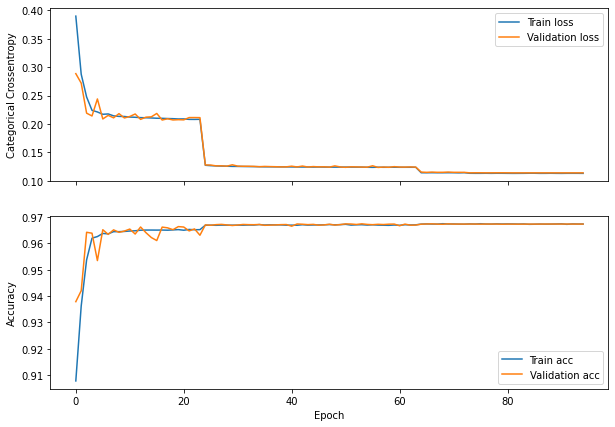

In [50]:
show_history(f'{path}/history_best_model.pkl')

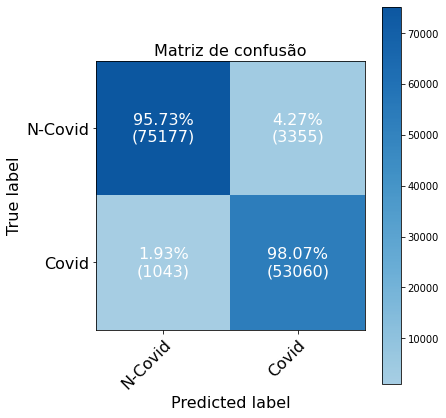

None

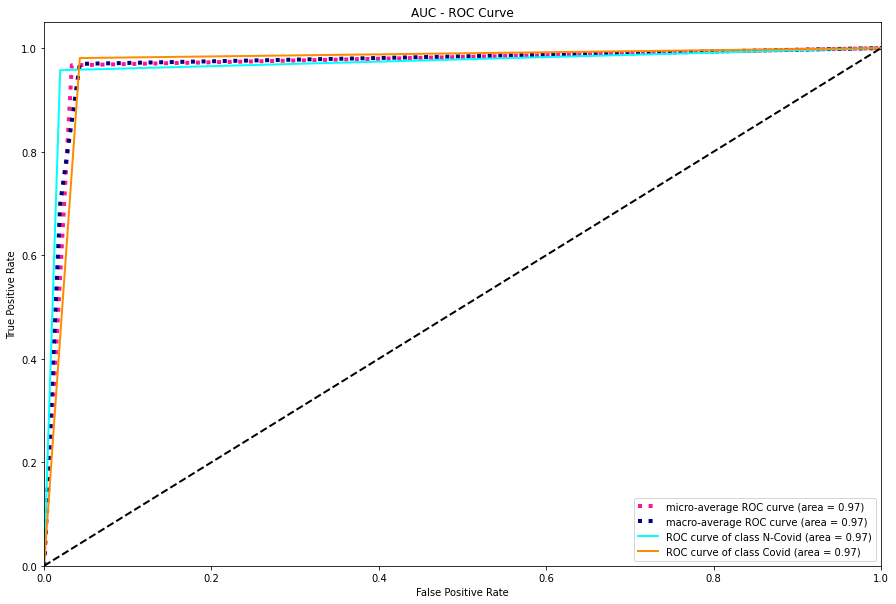

None

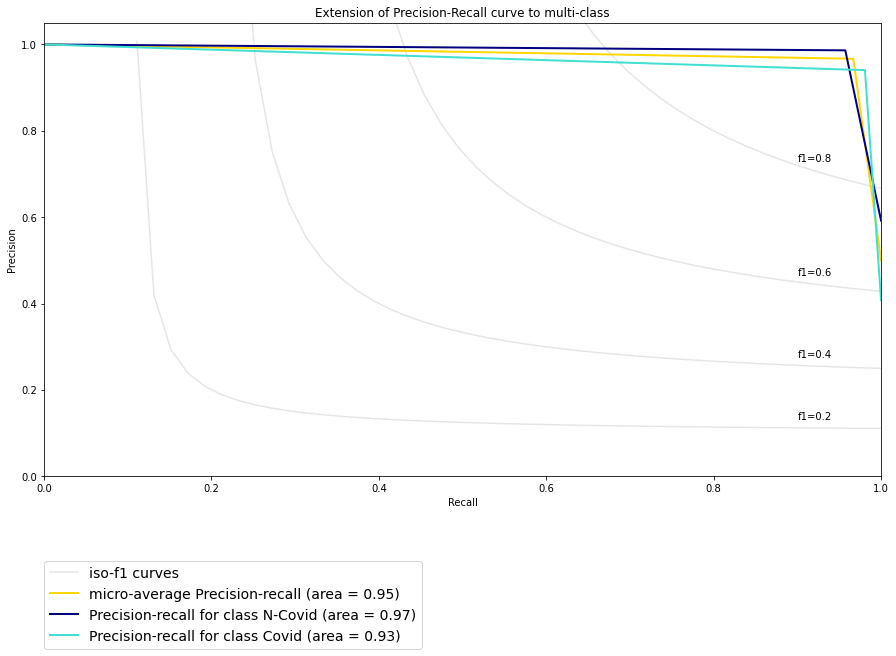

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,N-Covid,0.97,0.97,0.97,0.99,0.96,0.98,0.97
1,Covid,0.96,0.97,0.93,0.94,0.98,0.96,0.97
2,Média,0.96,0.97,0.95,0.96,0.97,0.97,0.97


In [51]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['N-Covid', 'Covid'],
    path=path
)

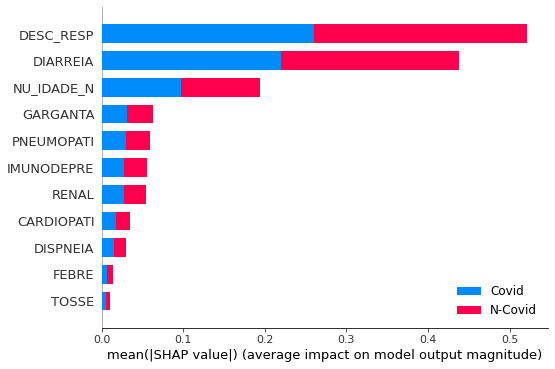

In [52]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
e = shap.GradientExplainer(model, background)
samples = x_test[np.random.choice(x_test.shape[0], 5000, replace=False)]
shap_values = e.shap_values(samples)

shap.summary_plot(shap_values, samples, feature_names=x_cols, show=False, class_names=['N-Covid', 'Covid'])
plt.savefig(f'{path}/shap_summary.png')

In [36]:
# class_names = ['N-Covid', 'Covid']
# for feat in x_cols:
#     for clss in range(len(class_names)):
#         shap.dependence_plot(
#             feat,
#             shap_values[clss],
#             samples,
#             interaction_index='NU_IDADE_N',
#             alpha=0.5,
#             feature_names=x_cols,
#             show=False
#         )
#         plt.savefig(f'{path_mlpcovid}/dependence/{class_names[clss]}_{feat}.png')

#### RNA (MLP) K-FOLD

In [53]:
path_mcfold = f'{OUTPUT}/ODS/covid-ncovid/mlp/r_per_sat_down_hep_neu_obe_sex/kfold'

Epoch 1/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.3612 - acc: 0.9174 - precision_m: 0.9175 - recall_m: 0.9175 - f1_m: 0.9175 - auc: 0.9621
Epoch 2/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2690 - acc: 0.9468 - precision_m: 0.9468 - recall_m: 0.9468 - f1_m: 0.9468 - auc: 0.9783
Epoch 3/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2322 - acc: 0.9614 - precision_m: 0.9614 - recall_m: 0.9614 - f1_m: 0.9614 - auc: 0.9855
Epoch 4/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2256 - acc: 0.9630 - precision_m: 0.9630 - recall_m: 0.9630 - f1_m: 0.9630 - auc: 0.9866
Epoch 5/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2231 - acc: 0.9636 - precision_m: 0.9636 - recall_m: 0.9636 - f1_m: 0.9636 - auc: 0.9869
Epoch 6/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2217 - acc: 0.9638 - precision_m: 0.9638 - recall_m: 0.9638 - f1_m: 0.9638 - auc:

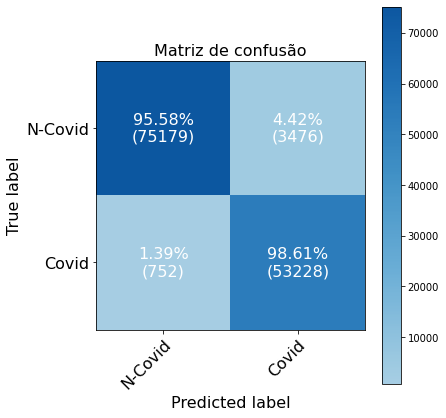

None

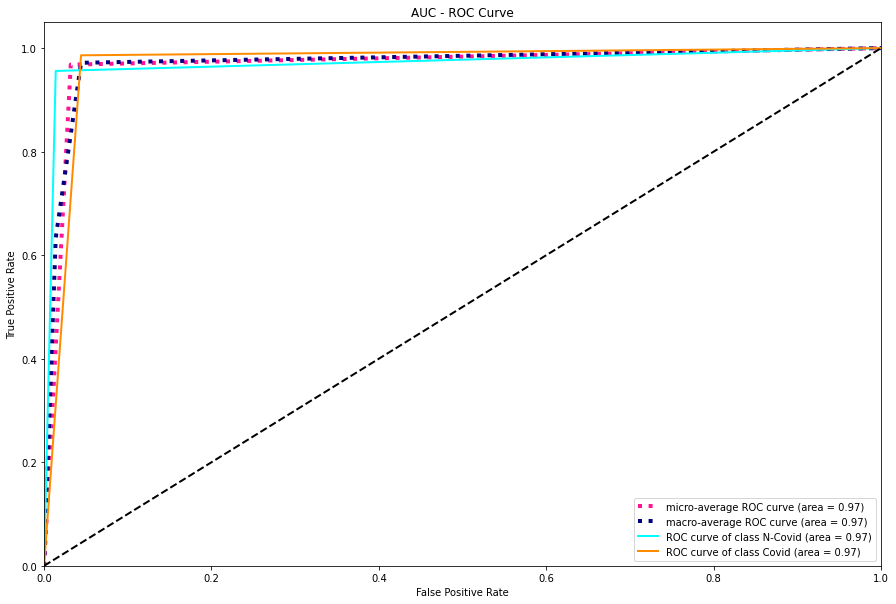

None

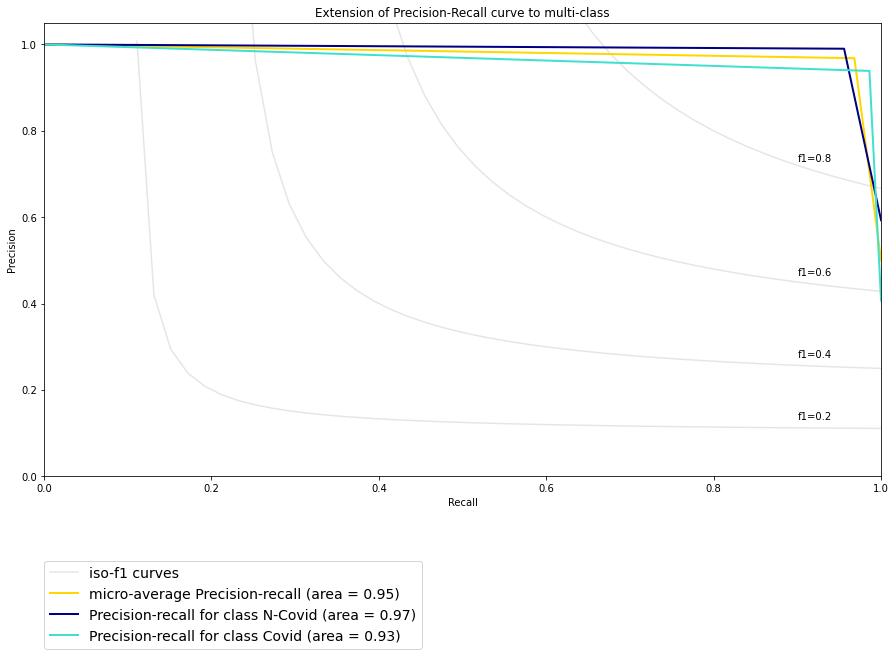

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.97     0.97     0.97       0.99    0.96         0.99      0.97
1    Covid  0.96     0.97     0.93       0.94    0.99         0.96      0.97
2    Média  0.96     0.97     0.95       0.96    0.98         0.98      0.97
Epoch 1/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.3617 - acc: 0.9174 - precision_m: 0.9174 - recall_m: 0.9174 - f1_m: 0.9174 - auc: 0.9620
Epoch 2/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2787 - acc: 0.9416 - precision_m: 0.9416 - recall_m: 0.9416 - f1_m: 0.9416 - auc: 0.9759
Epoch 3/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2356 - acc: 0.9604 - precision_m: 0.9604 - recall_m: 0.9604 - f1_m: 0.9604 - auc: 0.9849
Epoch 4/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2263 - acc: 0.9626 - precision_m: 0.9626 - recall_m: 0.9626 - f1_m: 0.9626 - auc: 0.9865
Epoch 5/150
2964/296

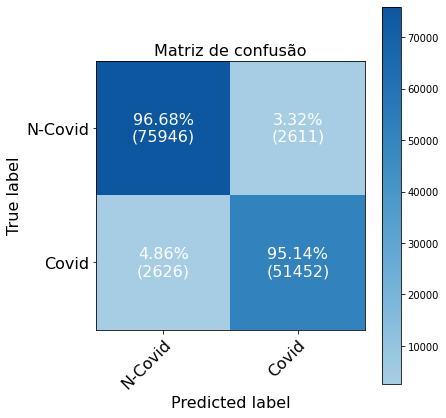

None

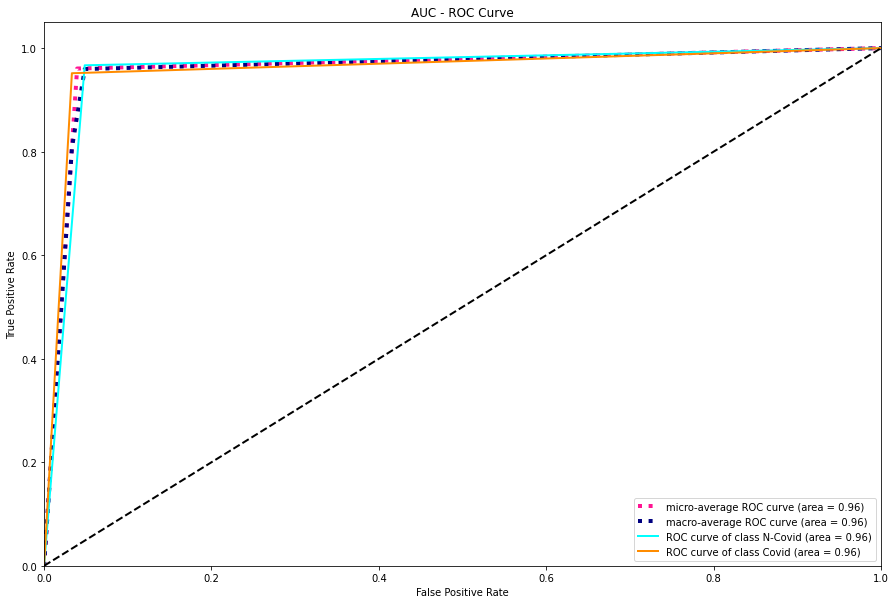

None

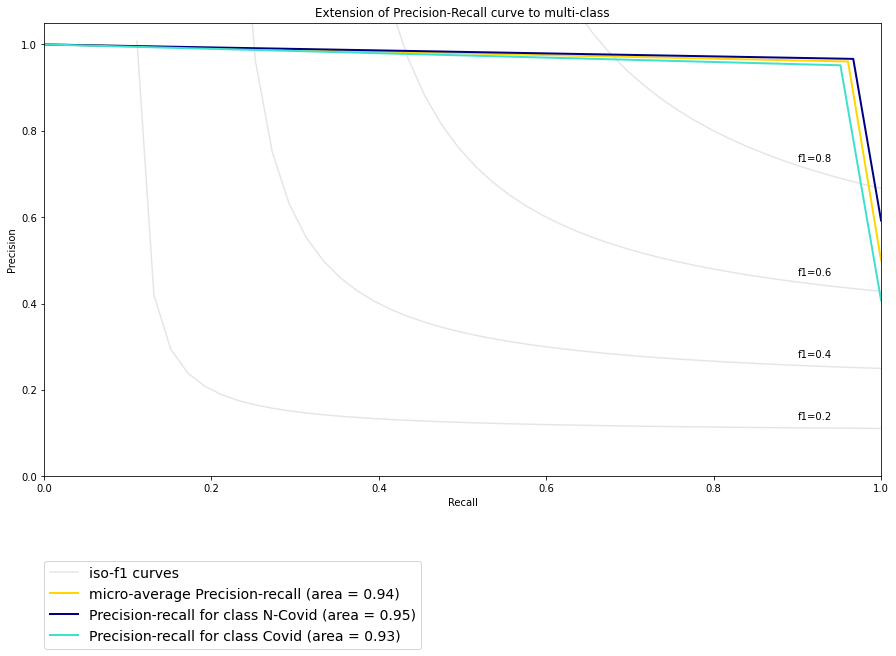

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.97     0.96     0.95       0.97    0.97         0.95      0.96
1    Covid  0.95     0.96     0.93       0.95    0.95         0.97      0.96
2    Média  0.96     0.96     0.94       0.96    0.96         0.96      0.96
Epoch 1/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.3594 - acc: 0.9184 - precision_m: 0.9184 - recall_m: 0.9184 - f1_m: 0.9184 - auc: 0.9634
Epoch 2/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2943 - acc: 0.9370 - precision_m: 0.9370 - recall_m: 0.9370 - f1_m: 0.9370 - auc: 0.9746
Epoch 3/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2403 - acc: 0.9579 - precision_m: 0.9579 - recall_m: 0.9579 - f1_m: 0.9579 - auc: 0.9839
Epoch 4/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2219 - acc: 0.9625 - precision_m: 0.9625 - recall_m: 0.9625 - f1_m: 0.9625 - auc: 0.9872
Epoch 5/150
2964/296

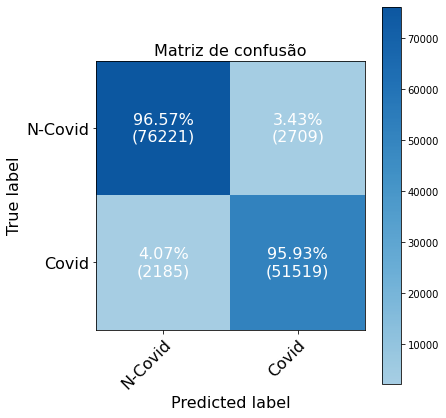

None

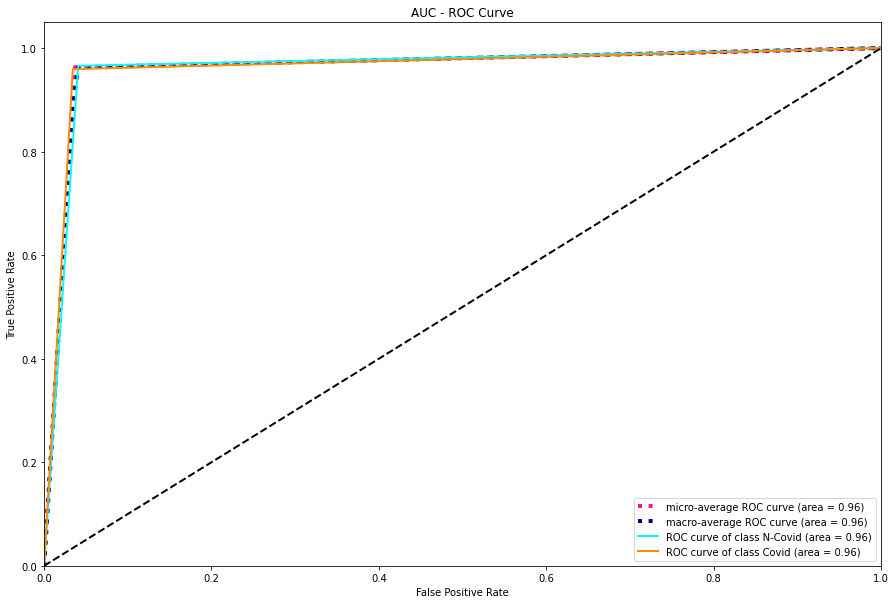

None

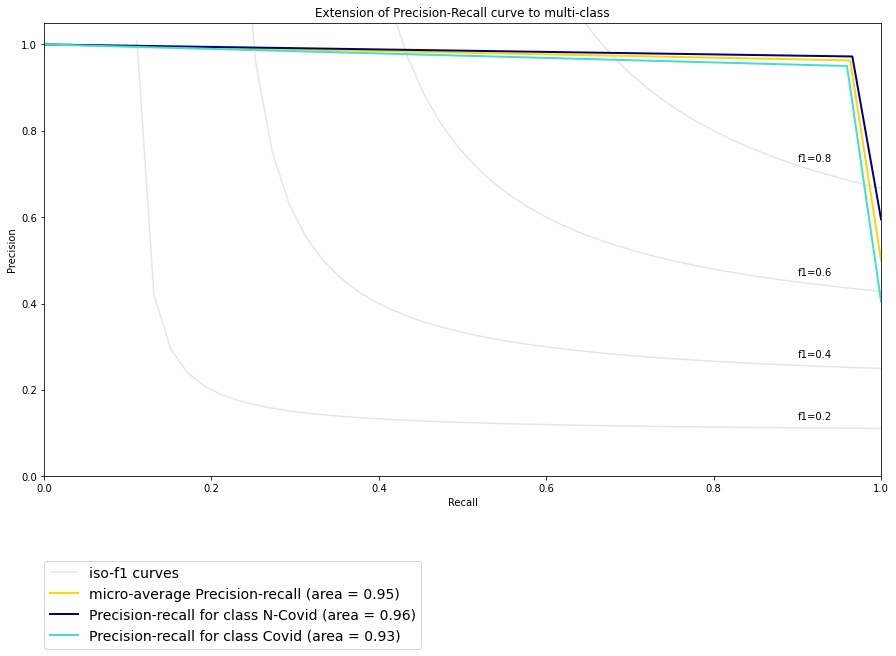

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.97     0.96     0.96       0.97    0.97         0.96      0.96
1    Covid  0.95     0.96     0.93       0.95    0.96         0.97      0.96
2    Média  0.96     0.96     0.94       0.96    0.96         0.96      0.96
Epoch 1/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.3537 - acc: 0.9194 - precision_m: 0.9194 - recall_m: 0.9194 - f1_m: 0.9194 - auc: 0.9641
Epoch 2/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2627 - acc: 0.9483 - precision_m: 0.9484 - recall_m: 0.9484 - f1_m: 0.9484 - auc: 0.9799A: 4s - loss: 0.2
Epoch 3/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2246 - acc: 0.9619 - precision_m: 0.9619 - recall_m: 0.9619 - f1_m: 0.9619 - auc: 0.9864
Epoch 4/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2215 - acc: 0.9629 - precision_m: 0.9629 - recall_m: 0.9629 - f1_m: 0.9629 - auc: 0.9868
Epo

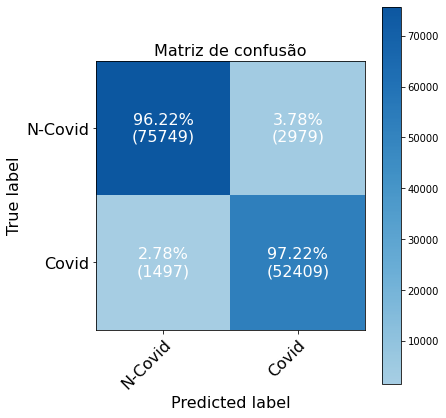

None

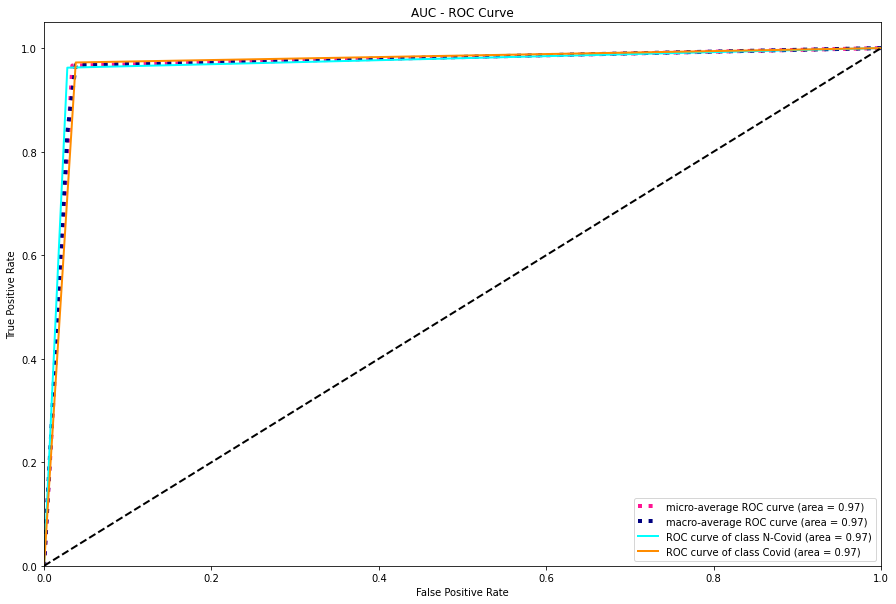

None

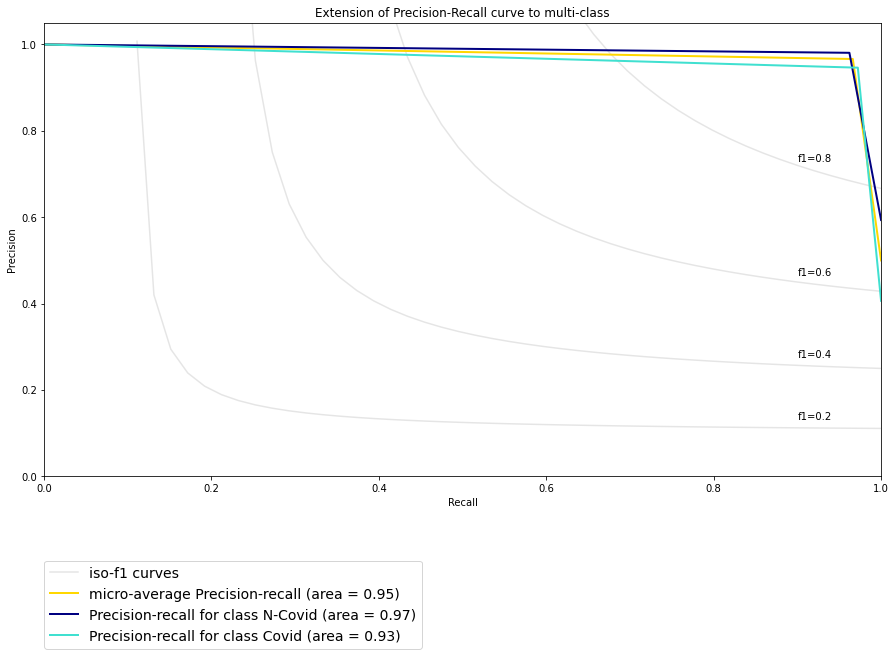

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.97     0.97     0.97       0.98    0.96         0.97      0.97
1    Covid  0.96     0.97     0.93       0.95    0.97         0.96      0.97
2    Média  0.96     0.97     0.95       0.96    0.96         0.96      0.97
Epoch 1/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.3532 - acc: 0.9190 - precision_m: 0.9190 - recall_m: 0.9190 - f1_m: 0.9190 - auc: 0.9642
Epoch 2/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2686 - acc: 0.9450 - precision_m: 0.9450 - recall_m: 0.9450 - f1_m: 0.9450 - auc: 0.9788
Epoch 3/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2240 - acc: 0.9619 - precision_m: 0.9619 - recall_m: 0.9619 - f1_m: 0.9619 - auc: 0.9868
Epoch 4/150
2964/2964 [==============================] - 6s 2ms/step - loss: 0.2200 - acc: 0.9630 - precision_m: 0.9630 - recall_m: 0.9630 - f1_m: 0.9630 - auc: 0.9873
Epoch 5/150
2964/296

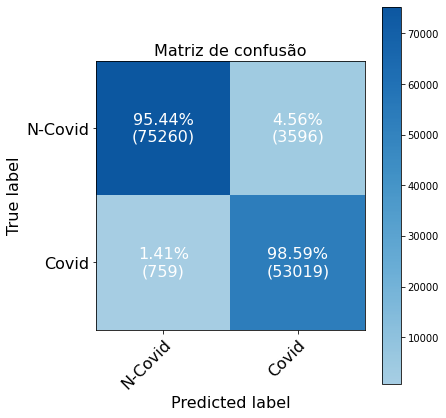

None

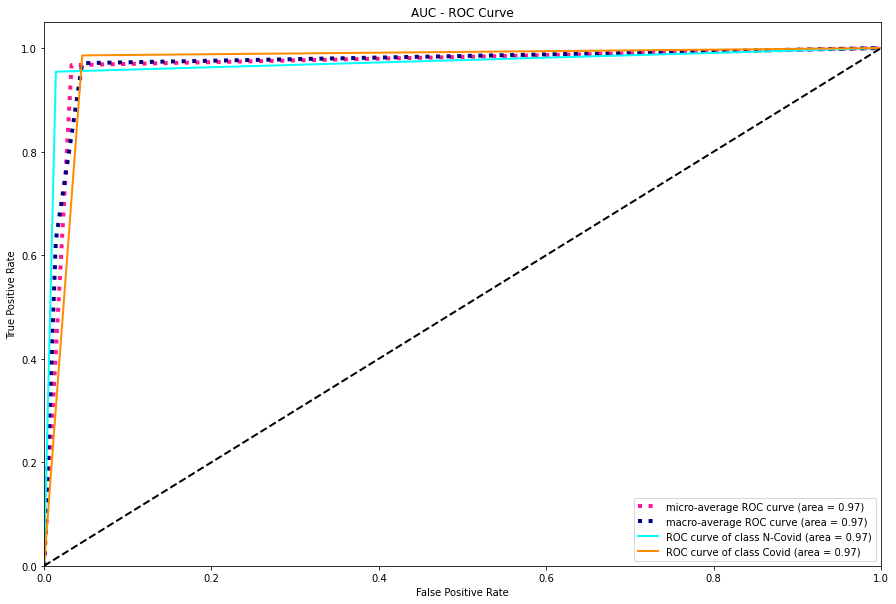

None

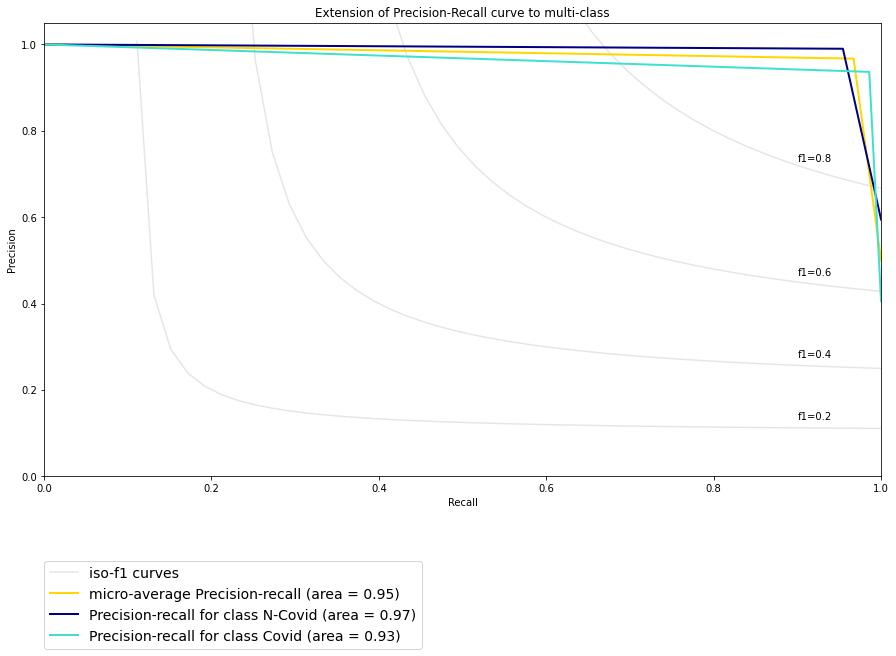

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.97     0.97     0.97       0.99    0.95         0.99      0.97
1    Covid  0.96     0.97     0.93       0.94    0.99         0.95      0.97
2    Média  0.96     0.97     0.95       0.96    0.97         0.97      0.97


In [54]:
x = covid_ncovid[x_cols]
y = covid_ncovid[y_cols]

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    
    x_scaler = MinMaxScaler(feature_range=(0, 1))
#     y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    y_train = tf.keras.utils.to_categorical(y.values[train])
#     y_train = y_scaler.fit_transform(y.values[train])

    # Load model
    model = mlp_covid_model((x_train.shape[1],))
    # Fit the model
    model.fit(x_train, y_train, epochs=150, batch_size=179)
    
    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)
    
    out = f'{path_mcfold}/{i}fold'
    sync_path(out)
    
    lbs = ['N-Covid', 'Covid']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [55]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{path_mcfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
N-Covid 0-fold,0.97,0.97,0.97,0.99,0.96,0.99,0.97
N-Covid 1-fold,0.97,0.96,0.95,0.97,0.97,0.95,0.96
N-Covid 2-fold,0.97,0.96,0.96,0.97,0.97,0.96,0.96
N-Covid 3-fold,0.97,0.97,0.97,0.98,0.96,0.97,0.97
N-Covid 4-fold,0.97,0.97,0.97,0.99,0.95,0.99,0.97
Avg,0.97,0.97,0.96,0.98,0.96,0.97,0.97
Std,0.00,0.01,0.01,0.01,0.01,0.02,0.01


,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Covid 0-fold,0.96,0.97,0.93,0.94,0.99,0.96,0.97
Covid 1-fold,0.95,0.96,0.93,0.95,0.95,0.97,0.96
Covid 2-fold,0.95,0.96,0.93,0.95,0.96,0.97,0.96
Covid 3-fold,0.96,0.97,0.93,0.95,0.97,0.96,0.97
Covid 4-fold,0.96,0.97,0.93,0.94,0.99,0.95,0.97
Avg,0.96,0.97,0.93,0.95,0.97,0.96,0.97
Std,0.01,0.01,0.00,0.01,0.02,0.01,0.01


#### RNA (CNN1D)

Preparação dos dados para CNN1D

In [97]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))

np.save(f'{path_dfcovid}/cnn/xtrain.npy', x_train)
np.save(f'{path_dfcovid}/cnn/xtest.npy', x_val)
np.save(f'{path_dfcovid}/cnn/xval.npy', x_val)

np.save(f'{path_dfcovid}/cnn/ytrain_cc.npy', y_train)
np.save(f'{path_dfcovid}/cnn/ytest_cc.npy', y_test)
np.save(f'{path_dfcovid}/cnn/yval_cc.npy', y_val)

In [98]:
path_cnncovid = f'{OUTPUT}/ALL/covid-ncovid/cnn'

Arquitetura gerada

In [78]:
# model = tf.keras.models.load_model(
#     f'{path_cnncovid}/best_model.h5',
#     custom_objects = {
#         'precision_m': precision_m,
#         'recall_m': recall_m,
#         'f1_m': f1_m
#     }
# )
# model.summary()

In [99]:
def cnn_covid_model(input_shape: ()) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    # tf.random.set_seed(0)

    opt = tf.keras.optimizers.Adagrad(lr=0.148264721208473)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='cnn1d')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same'))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='softmax'))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='tanh'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [100]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_cnncovid}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{path_cnncovid}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-5, mode='min'),
]

In [101]:
model = cnn_covid_model((x_train.shape[1],x_train.shape[2]))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=179,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_cnncovid}/best_model.h5')

with open(f'{path_cnncovid}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/200
2253/2253 [==============================] - 9s 4ms/step - loss: 0.4826 - acc: 0.7331 - precision_m: 0.7331 - recall_m: 0.7331 - f1_m: 0.7331 - auc: 0.8259 - val_loss: 0.1321 - val_acc: 0.9579 - val_precision_m: 0.9579 - val_recall_m: 0.9579 - val_f1_m: 0.9579 - val_auc: 0.9874 - lr: 0.1483
Epoch 2/200
2253/2253 [==============================] - 10s 4ms/step - loss: 0.1144 - acc: 0.9653 - precision_m: 0.9653 - recall_m: 0.9653 - f1_m: 0.9653 - auc: 0.9896 - val_loss: 0.1071 - val_acc: 0.9671 - val_precision_m: 0.9671 - val_recall_m: 0.9671 - val_f1_m: 0.9671 - val_auc: 0.9908 - lr: 0.1483
Epoch 3/200
2253/2253 [==============================] - 9s 4ms/step - loss: 0.1066 - acc: 0.9676 - precision_m: 0.9676 - recall_m: 0.9676 - f1_m: 0.9676 - auc: 0.9908 - val_loss: 0.1061 - val_acc: 0.9678 - val_precision_m: 0.9678 - val_recall_m: 0.9678 - val_f1_m: 0.9678 - val_auc: 0.9909 - lr: 0.1483
Epoch 4/200
2253/2253 [==============================] - 9s 4ms/step - loss: 0.1033 - a

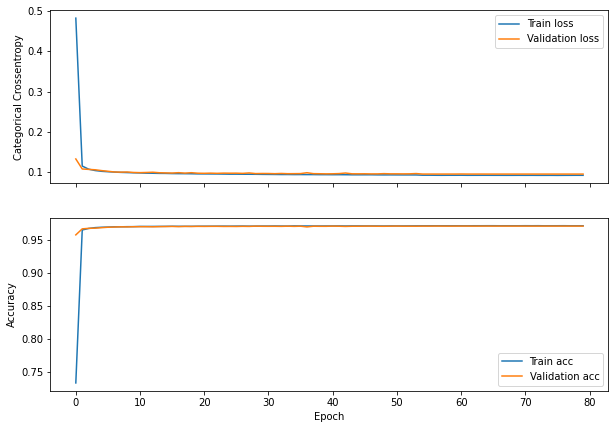

In [102]:
show_history(f'{path_cnncovid}/history_best_model.pkl')

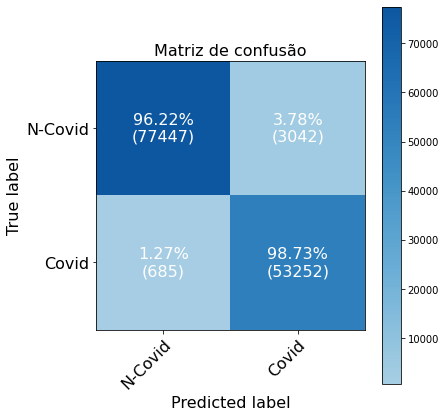

None

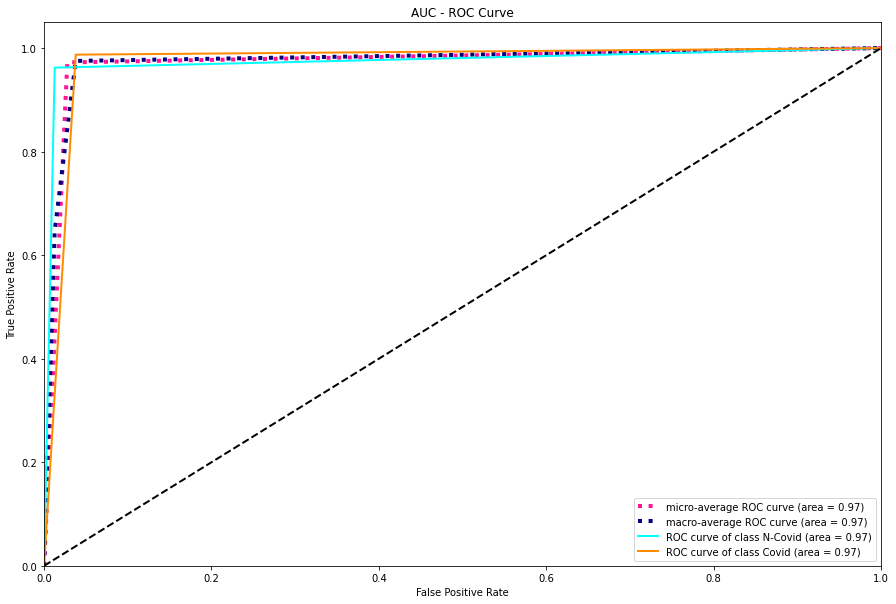

None

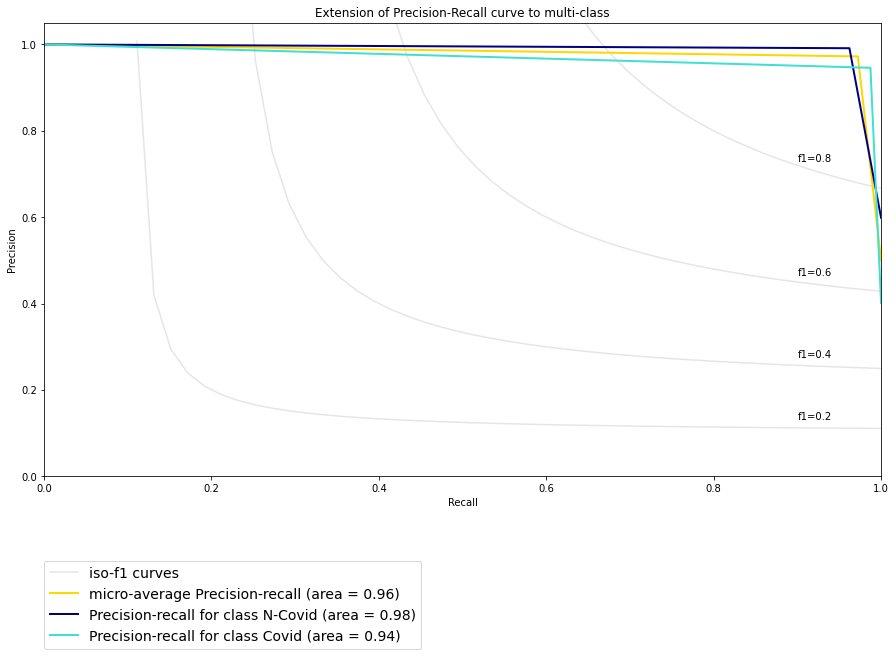

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,N-Covid,0.98,0.97,0.98,0.99,0.96,0.99,0.97
1,Covid,0.97,0.97,0.94,0.95,0.99,0.96,0.97
2,Média,0.98,0.97,0.96,0.97,0.98,0.98,0.97


In [103]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['N-Covid', 'Covid'],
    path=path_cnncovid
)

#### RNA (CNN) K-FOLD

In [107]:
path_ccfold = f'{OUTPUT}/ALL/covid-ncovid/cnn/kfold'

Epoch 1/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.3523 - acc: 0.8176 - precision_m: 0.8176 - recall_m: 0.8176 - f1_m: 0.8176 - auc: 0.9151
Epoch 2/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1099 - acc: 0.9665 - precision_m: 0.9665 - recall_m: 0.9665 - f1_m: 0.9665 - auc: 0.9903
Epoch 3/100
3004/3004 [==============================] - 10s 3ms/step - loss: 0.1045 - acc: 0.9683 - precision_m: 0.9683 - recall_m: 0.9683 - f1_m: 0.9683 - auc: 0.9911
Epoch 4/100
3004/3004 [==============================] - 9s 3ms/step - loss: 0.1019 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9915
Epoch 5/100
3004/3004 [==============================] - 9s 3ms/step - loss: 0.1002 - acc: 0.9697 - precision_m: 0.9697 - recall_m: 0.9697 - f1_m: 0.9697 - auc: 0.9918
Epoch 6/100
3004/3004 [==============================] - 9s 3ms/step - loss: 0.0991 - acc: 0.9702 - precision_m: 0.9701 - recall_m: 0.9701 - f1_m: 0.9701 - auc

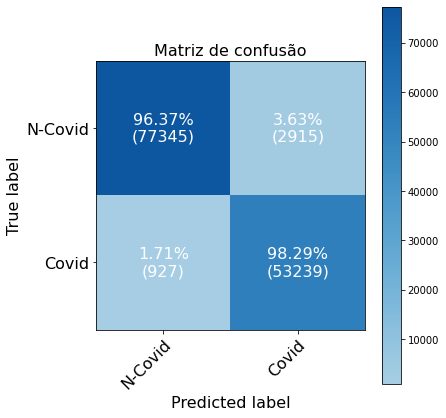

None

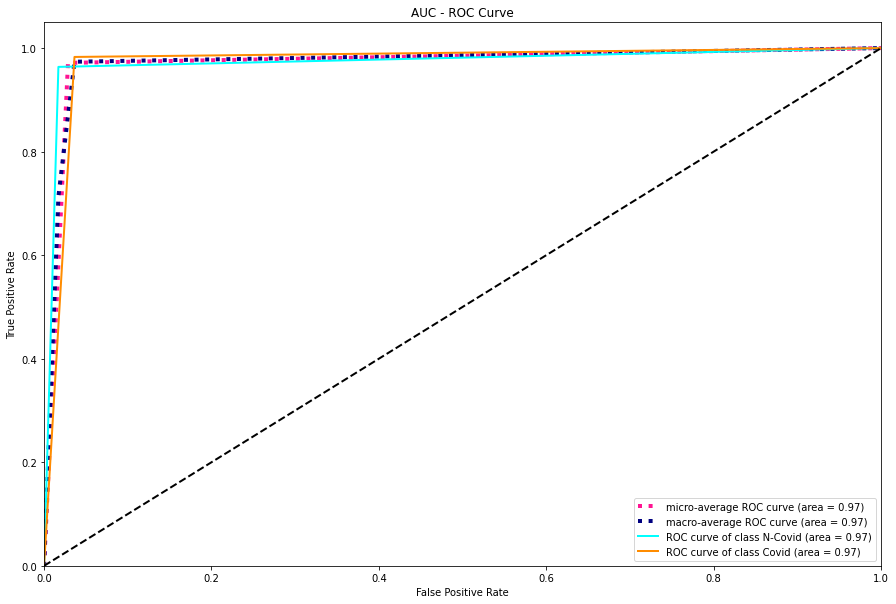

None

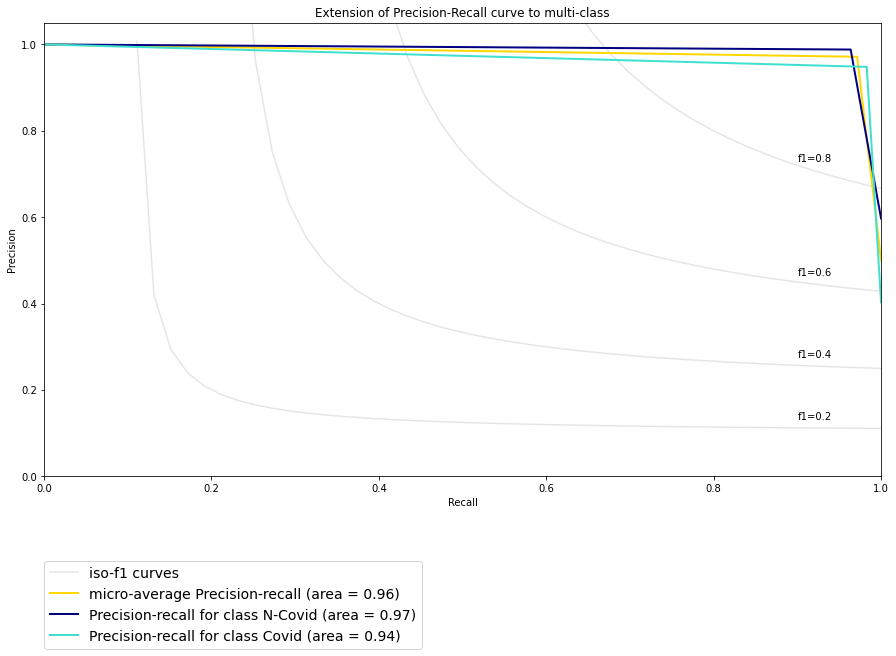

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.98     0.97     0.97       0.99    0.96         0.98      0.97
1    Covid  0.97     0.97     0.94       0.95    0.98         0.96      0.97
2    Média  0.98     0.97     0.96       0.97    0.97         0.97      0.97
Epoch 1/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.3475 - acc: 0.8207 - precision_m: 0.8207 - recall_m: 0.8207 - f1_m: 0.8207 - auc: 0.9184
Epoch 2/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1099 - acc: 0.9666 - precision_m: 0.9666 - recall_m: 0.9666 - f1_m: 0.9666 - auc: 0.9904
Epoch 3/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1054 - acc: 0.9679 - precision_m: 0.9679 - recall_m: 0.9679 - f1_m: 0.9679 - auc: 0.9910
Epoch 4/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1032 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9914
Epoch 5/100
3004/300

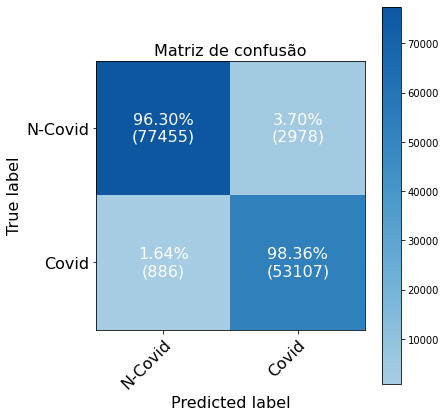

None

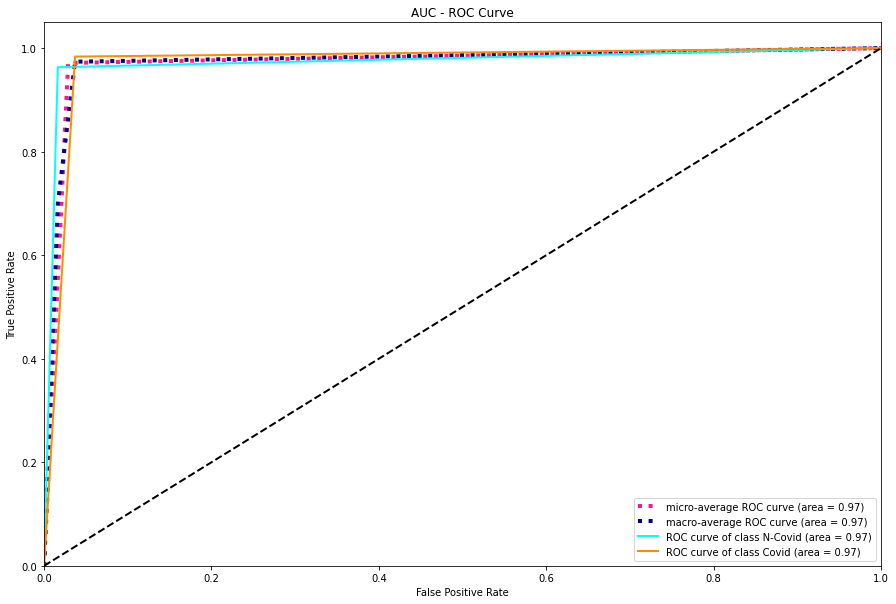

None

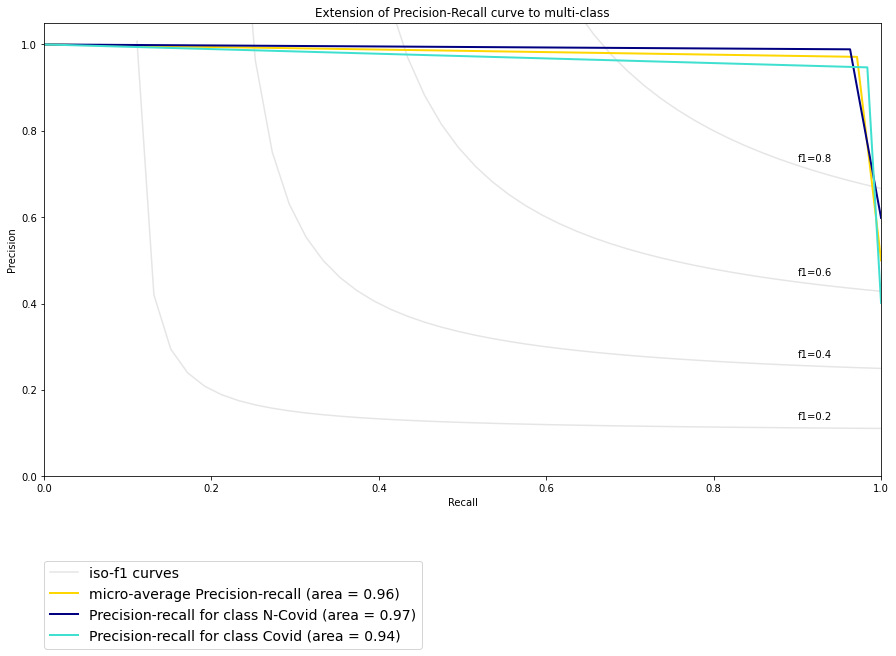

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.98     0.97     0.97       0.99    0.96         0.98      0.97
1    Covid  0.96     0.97     0.94       0.95    0.98         0.96      0.97
2    Média  0.97     0.97     0.96       0.97    0.97         0.97      0.97
Epoch 1/100
3004/3004 [==============================] - 9s 3ms/step - loss: 0.3594 - acc: 0.8134 - precision_m: 0.8134 - recall_m: 0.8134 - f1_m: 0.8134 - auc: 0.9121
Epoch 2/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1089 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671 - auc: 0.9904
Epoch 3/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1033 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9692 - f1_m: 0.9692 - auc: 0.9912
Epoch 4/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1011 - acc: 0.9698 - precision_m: 0.9698 - recall_m: 0.9698 - f1_m: 0.9698 - auc: 0.9916
Epoch 5/100
3004/300

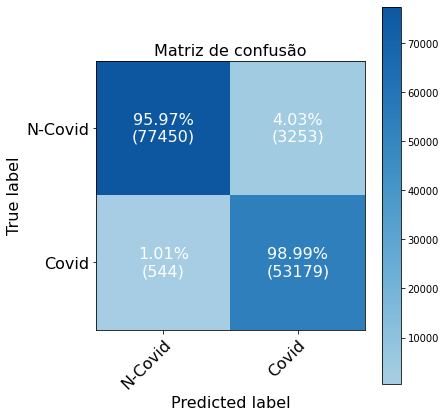

None

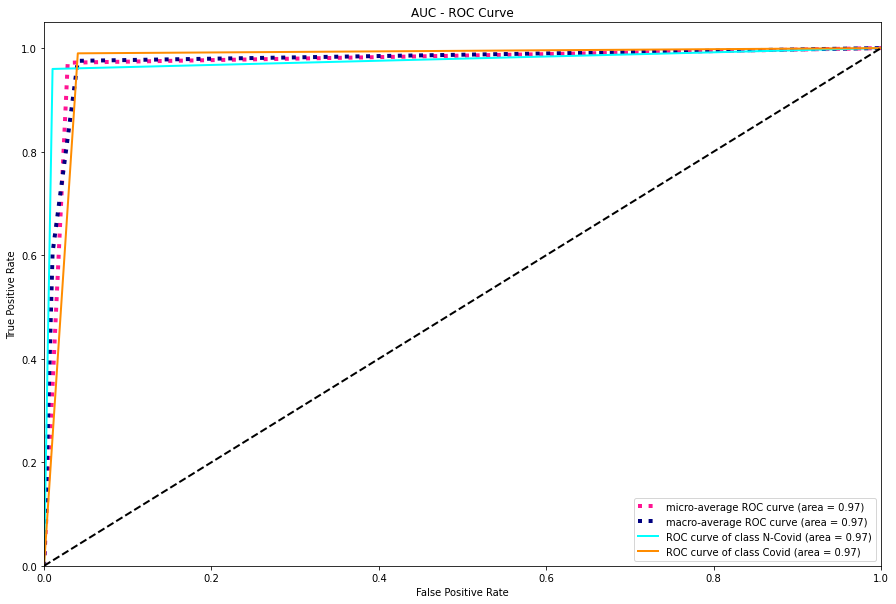

None

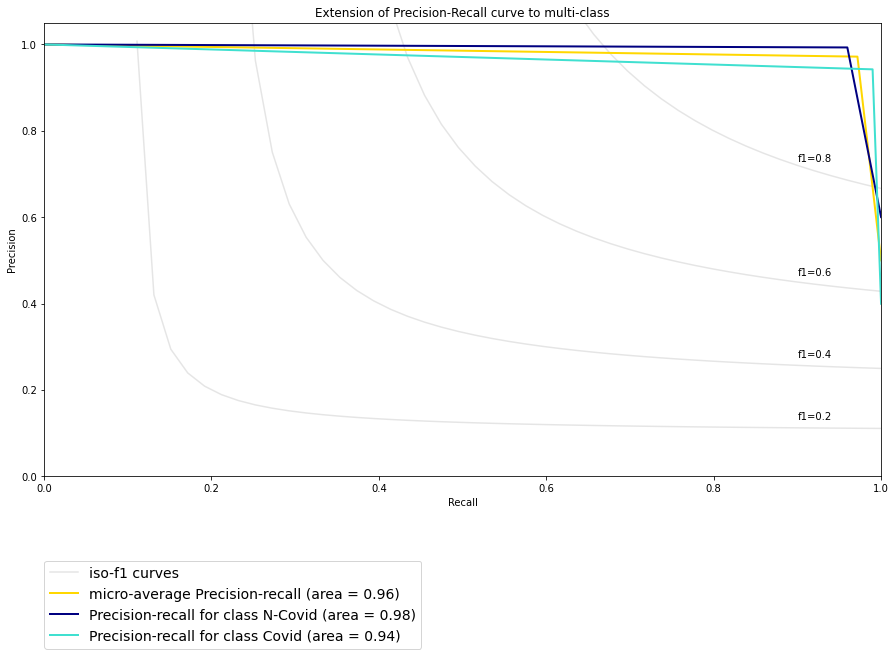

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.98     0.97     0.98       0.99    0.96         0.99      0.97
1    Covid  0.97     0.97     0.94       0.94    0.99         0.96      0.97
2    Média  0.98     0.97     0.96       0.96    0.98         0.98      0.97
Epoch 1/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.3341 - acc: 0.8303 - precision_m: 0.8303 - recall_m: 0.8303 - f1_m: 0.8303 - auc: 0.9255
Epoch 2/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1084 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9905
Epoch 3/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1028 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9692 - f1_m: 0.9692 - auc: 0.9913
Epoch 4/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1004 - acc: 0.9698 - precision_m: 0.9698 - recall_m: 0.9698 - f1_m: 0.9698 - auc: 0.9918
Epoch 5/100
3004/300

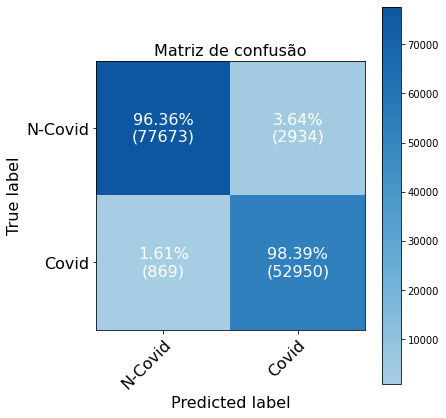

None

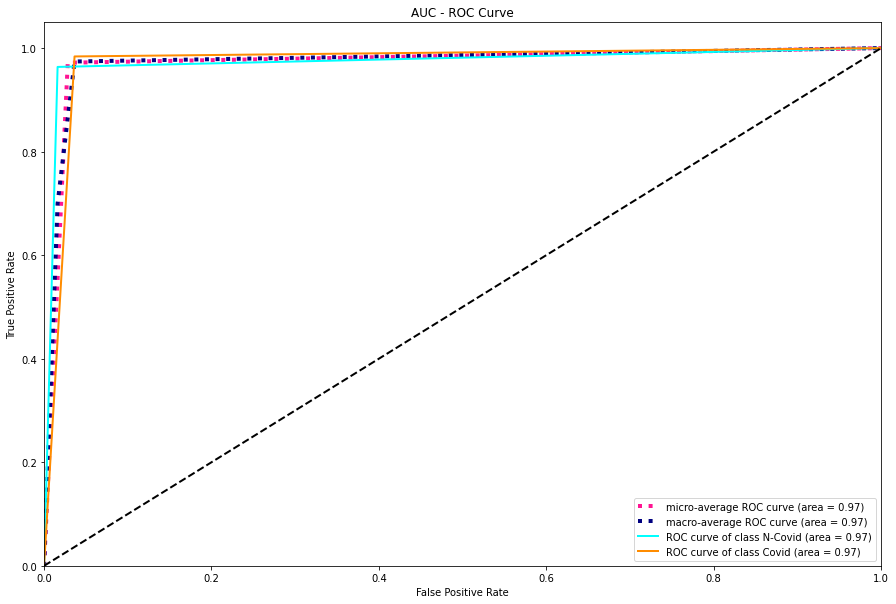

None

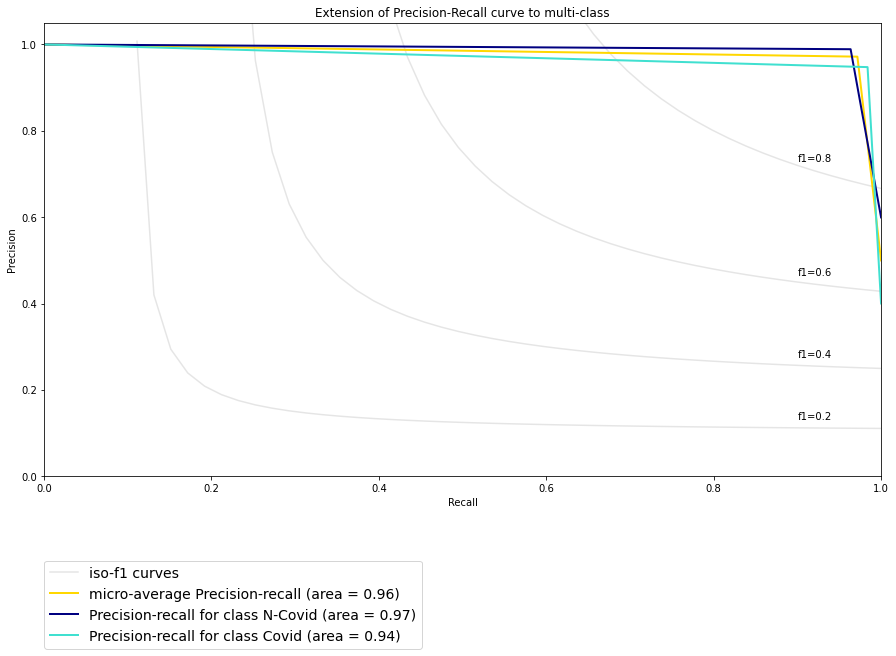

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.98     0.97     0.97       0.99    0.96         0.98      0.97
1    Covid  0.97     0.97     0.94       0.95    0.98         0.96      0.97
2    Média  0.98     0.97     0.96       0.97    0.97         0.97      0.97
Epoch 1/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.3849 - acc: 0.7955 - precision_m: 0.7955 - recall_m: 0.7955 - f1_m: 0.7955 - auc: 0.8962
Epoch 2/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1097 - acc: 0.9667 - precision_m: 0.9667 - recall_m: 0.9667 - f1_m: 0.9667 - auc: 0.9903
Epoch 3/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1040 - acc: 0.9687 - precision_m: 0.9687 - recall_m: 0.9687 - f1_m: 0.9687 - auc: 0.9911
Epoch 4/100
3004/3004 [==============================] - 8s 3ms/step - loss: 0.1018 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9915
Epoch 5/100
3004/300

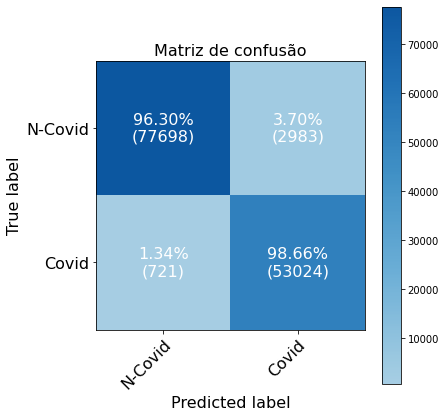

None

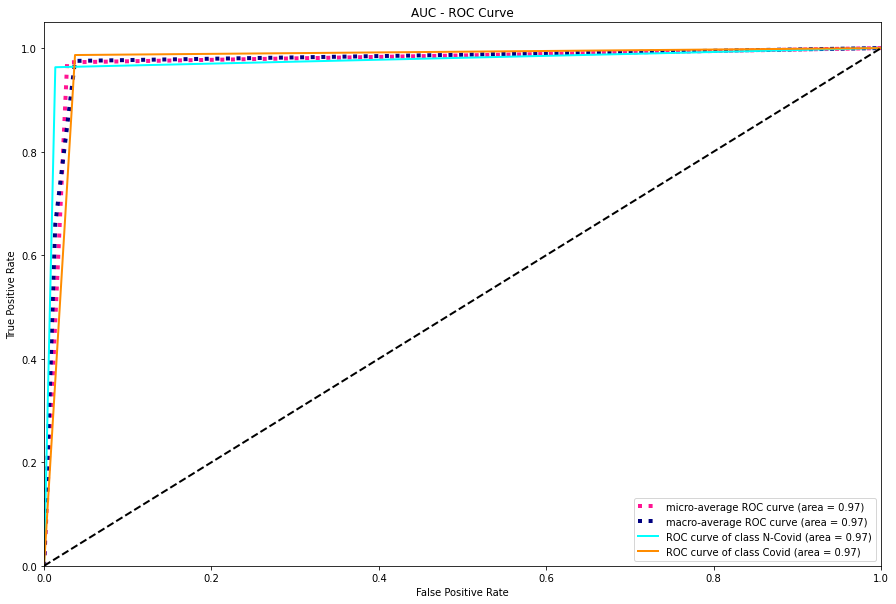

None

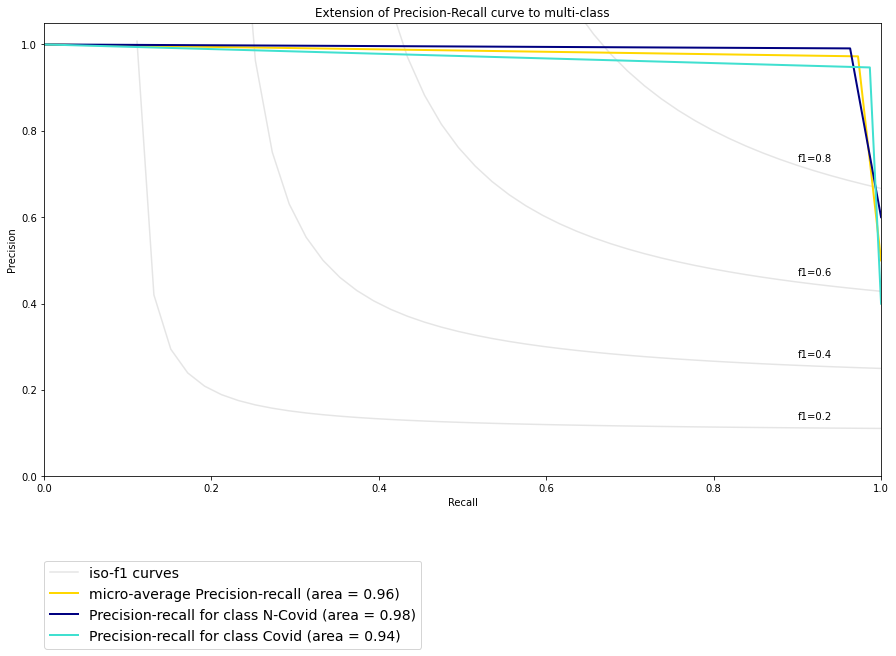

None

   Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0  N-Covid  0.98     0.97     0.98       0.99    0.96         0.99      0.97
1    Covid  0.97     0.97     0.94       0.95    0.99         0.96      0.97
2    Média  0.98     0.97     0.96       0.97    0.98         0.98      0.97


In [108]:
x = covid_ncovid[x_cols]
y = covid_ncovid[y_cols]

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    
    x_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = tf.keras.utils.to_categorical(y.values[train])

    # Load model
    model = cnn_covid_model((x_train.shape[1],x_train.shape[2]))
    # Fit the model
    model.fit(x_train, y_train, epochs=100, batch_size=179)
    
    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)
    
    out = f'{path_ccfold}/{i}fold'
    sync_path(out)
    
    lbs = ['N-Covid', 'Covid']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [109]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{path_ccfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
N-Covid 0-fold,0.98,0.97,0.97,0.99,0.96,0.98,0.97
N-Covid 1-fold,0.98,0.97,0.97,0.99,0.96,0.98,0.97
N-Covid 2-fold,0.98,0.97,0.98,0.99,0.96,0.99,0.97
N-Covid 3-fold,0.98,0.97,0.97,0.99,0.96,0.98,0.97
N-Covid 4-fold,0.98,0.97,0.98,0.99,0.96,0.99,0.97
Avg,0.98,0.97,0.97,0.99,0.96,0.98,0.97
Std,0.00,0.00,0.01,0.00,0.00,0.01,0.00


,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Covid 0-fold,0.97,0.97,0.94,0.95,0.98,0.96,0.97
Covid 1-fold,0.96,0.97,0.94,0.95,0.98,0.96,0.97
Covid 2-fold,0.97,0.97,0.94,0.94,0.99,0.96,0.97
Covid 3-fold,0.97,0.97,0.94,0.95,0.98,0.96,0.97
Covid 4-fold,0.97,0.97,0.94,0.95,0.99,0.96,0.97
Avg,0.97,0.97,0.94,0.95,0.98,0.96,0.97
Std,0.00,0.00,0.00,0.00,0.01,0.00,0.00


#### DEPLOY TRAINING RNA (MLP)

In [56]:
path_deploy = f'{OUTPUT}/ODS/covid-ncovid/mlp/r_per_sat_down_hep_neu_obe_sex/deploy'

In [57]:
x_scaler = MinMaxScaler((0,1))
x_train = x_scaler.fit_transform(covid_ncovid[x_cols])

In [58]:
pickle.dump(x_scaler, open(f'{path_deploy}/xscaler.pkl', 'wb'))

OHE

In [59]:
y_train = tf.keras.utils.to_categorical(covid_ncovid[y_cols])

Training

In [60]:
model = mlp_covid_model((x_train.shape[1],))
# train the neural network
H = model.fit(x_train, y_train, epochs=150, batch_size=179)

# Uncomment if you don't use callbacks
model.save(f'{path_deploy}/model.h5')

with open(f'{path_deploy}/history_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.3460 - acc: 0.9207 - precision_m: 0.9207 - recall_m: 0.9207 - f1_m: 0.9207 - auc: 0.9643
Epoch 2/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.2620 - acc: 0.9508 - precision_m: 0.9508 - recall_m: 0.9508 - f1_m: 0.9508 - auc: 0.9808
Epoch 3/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.2279 - acc: 0.9628 - precision_m: 0.9628 - recall_m: 0.9628 - f1_m: 0.9628 - auc: 0.9863
Epoch 4/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.2232 - acc: 0.9636 - precision_m: 0.9636 - recall_m: 0.9636 - f1_m: 0.9636 - auc: 0.9872
Epoch 5/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.2229 - acc: 0.9637 - precision_m: 0.9637 - recall_m: 0.9637 - f1_m: 0.9637 - auc: 0.9872
Epoch 6/150
3705/3705 [==============================] - 7s 2ms/step - loss: 0.2189 - acc: 0.9643 - precision_m: 0.9643 - recall_m: 0.9643 - f1_m: 0.9643 - auc:

#### DEPLOY TRAINING RNA (CNN)

In [150]:
path_deploy = f'{OUTPUT}/ALL/covid-ncovid/cnn/deploy'

In [151]:
x_scaler = MinMaxScaler((0,1))
x_train = x_scaler.fit_transform(covid_ncovid[x_cols])

In [152]:
pickle.dump(x_scaler, open(f'{path_deploy}/xscaler.pkl', 'wb'))

OHE

In [153]:
y_train = tf.keras.utils.to_categorical(covid_ncovid[y_cols])

Preparação dos dados para CNN1D

In [154]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

Training

In [155]:
model = cnn_covid_model((x_train.shape[1],x_train.shape[2]))
# train the neural network
H = model.fit(x_train, y_train, epochs=10, batch_size=179)

# Uncomment if you don't use callbacks
model.save(f'{path_cnncovid}/model.h5')

with open(f'{path_cnncovid}/history_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/10
3755/3755 [==============================] - 10s 3ms/step - loss: 0.3168 - acc: 0.8397 - precision_m: 0.8397 - recall_m: 0.8397 - f1_m: 0.8397 - auc: 0.9332
Epoch 2/10
3755/3755 [==============================] - 11s 3ms/step - loss: 0.1070 - acc: 0.9676 - precision_m: 0.9676 - recall_m: 0.9676 - f1_m: 0.9676 - auc: 0.9907
Epoch 3/10
3755/3755 [==============================] - 11s 3ms/step - loss: 0.1019 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9915
Epoch 4/10
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0992 - acc: 0.9701 - precision_m: 0.9701 - recall_m: 0.9701 - f1_m: 0.9701 - auc: 0.9920
Epoch 5/10
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0979 - acc: 0.9704 - precision_m: 0.9704 - recall_m: 0.9704 - f1_m: 0.9704 - auc: 0.9923
Epoch 6/10
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0970 - acc: 0.9706 - precision_m: 0.9706 - recall_m: 0.9706 - f1_m: 0.9706 - auc: